# Imports

In [1]:
import pandas as pd
import pickle
%matplotlib inline

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import gensim

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sampling

from doc_embeddings import get_average_number_of_words
from doc_embeddings import create_vectors_for_recipe_id
from doc_embeddings import create_doc2vec_embeddings
from doc_embeddings import tsne_plot
from doc_embeddings import draw_scatter_per_category
from doc_embeddings import draw_scatter_with_labels
from doc_embeddings import TfidfEmbeddingVectorizer

# Constants

In [2]:
ING_CLEAN_NO_COMMON = '../cleaned_files/ingredients_clean_without_common_words.obj'
KEYWORDS_CLEAN = '../cleaned_files/keywords_cleaned.obj'
CATEGORIES_CLEAN = '../cleaned_files/categories_cleaned.obj'
NAMES_CLEAN = '../cleaned_files/names_cleaned.obj'


RECIPES_SMALL = "../EDA_files/recipes_small.parquet"
RATINGS_SMALL = "../EDA_files/ratings_small.parquet"
INDEX_TO_RECIPE_OBJ = "../EDA_files/index_to_recipe.obj"
RECIPE_TO_INDEX_OBJ = "../EDA_files/recipe_to_index.obj"
RECIPE_ID_TO_NAME_OBJ = "../EDA_files/recipe_id_to_name.obj"
RECIPE_ID_TO_CAT = "../EDA_files/recipe_id_to_category.obj"

CONCATENATED_ING_CAT_DF = "../samples/concatenated_ing_cat_df.obj"
CONCATENATED_ING_CAT_KEY_DF = "../samples/concatenated_ing_cat_key_df.obj"

# Load data

In [3]:
recipes_small = pd.read_parquet(RECIPES_SMALL)
ratings_small = pd.read_parquet(RATINGS_SMALL)

In [4]:
with open(ING_CLEAN_NO_COMMON, "rb") as input_file:
    ingredients_no_common_words = pickle.load(input_file)

with open(KEYWORDS_CLEAN, "rb") as input_file:
    keywords_clean = pickle.load(input_file)

with open(CATEGORIES_CLEAN, "rb") as input_file:
    categories_clean = pickle.load(input_file)
    
# with open(NAMES_CLEAN, "rb") as input_file:
#     names_clean = pickle.load(input_file)
    
with open(INDEX_TO_RECIPE_OBJ, "rb") as input_file:
    index_to_recipe = pickle.load(input_file)

with open(RECIPE_TO_INDEX_OBJ, "rb") as input_file:
    recipe_to_index = pickle.load(input_file)
    
with open(RECIPE_ID_TO_NAME_OBJ, "rb") as input_file:
    recipe_id_to_name = pickle.load(input_file)
    
with open(RECIPE_ID_TO_CAT, "rb") as input_file:
    recipe_id_to_cat = pickle.load(input_file)

In [5]:
# Merge ingredients, keywords and categories
concatenated_df = pd.DataFrame(ingredients_no_common_words).merge(keywords_clean, on='RecipeId').merge(categories_clean, on='RecipeId')
concatenated_df.RecipeCategory = concatenated_df.RecipeCategory.apply(lambda x: [x])

# Create dataframe for ids and lists of concatenated words
concatenated_lists = concatenated_df.Ingredients + concatenated_df.Keywords + concatenated_df.RecipeCategory
concatenated_lists = pd.DataFrame(concatenated_df['RecipeId']).merge(pd.DataFrame(concatenated_lists), 
                                                                     left_index=True, right_index=True)
concatenated_lists = concatenated_lists.rename(columns={0:'Concatenated'})

In [6]:
# Merge ingredients and categories
concatenated_no_key_df = pd.DataFrame(ingredients_no_common_words).merge(categories_clean, on='RecipeId')
concatenated_no_key_df.RecipeCategory = concatenated_no_key_df.RecipeCategory.apply(lambda x: [x])


# Create dataframe for ids and lists of concatenated words
concatenated_no_key_lists = concatenated_no_key_df.Ingredients + concatenated_no_key_df.RecipeCategory
concatenated_no_key_lists = pd.DataFrame(concatenated_no_key_df['RecipeId']).merge(pd.DataFrame(concatenated_no_key_lists), 
                                                                     left_index=True, right_index=True)
concatenated_no_key_lists = concatenated_no_key_lists.rename(columns={0:'Concatenated'})

## Save samples

In [7]:
# with open(CONCATENATED_ING_CAT_DF, 'wb') as pickle_file:
#     pickle.dump(concatenated_no_key_lists, pickle_file)

In [8]:
# with open(CONCATENATED_ING_CAT_KEY_DF, 'wb') as pickle_file:
#     pickle.dump(concatenated_lists, pickle_file)

# Word2Vec

## Ingredients

In [32]:
# create embeddings for ingredients

ids = ingredients_no_common_words['RecipeId']
corpus = ingredients_no_common_words['Ingredients']
window_size = get_average_number_of_words(corpus)
model_ing = Word2Vec(corpus, sg=0, workers=8, window=window_size, min_count=1, vector_size=100)

tfidf_ingredients, ingredient_vectors_dict = create_vectors_for_recipe_id(model_ing, 
                                                                         corpus, 
                                                                         ids)

## Keywords

In [33]:
# create embeddings for keywords

ids = keywords_clean['RecipeId']
corpus = keywords_clean['Keywords']
window_size = get_average_number_of_words(corpus)
model_keywords = Word2Vec(corpus, sg=0, workers=8, window=window_size, min_count=1, vector_size=100)

tfidf_keywords, keyword_vectors_dict = create_vectors_for_recipe_id(model_keywords, 
                                                                    corpus, 
                                                                    ids)

## Concatenated

In [34]:
# create embeddings for concatenated lists of ingredients, keywords and categories

ids = concatenated_lists['RecipeId']
corpus = concatenated_lists['Concatenated']
window_size = get_average_number_of_words(corpus)

model_concatenated = Word2Vec(corpus, sg=0, workers=8, window=window_size, min_count=1, vector_size=100)
tfidf_concatenated, concatenated_vectors_dict = create_vectors_for_recipe_id(model_concatenated, 
                                                                             corpus, 
                                                                             ids)

In [35]:
# create embeddings for concatenated lists of ingredients and categories

ids = concatenated_no_key_lists['RecipeId']
corpus = concatenated_no_key_lists['Concatenated']
window_size = get_average_number_of_words(corpus)

model_no_key_concatenated = Word2Vec(corpus, sg=0, workers=8, window=window_size, min_count=1, vector_size=100)
tfidf_no_key_concatenated, concatenated_no_key_vectors_dict = create_vectors_for_recipe_id(model_concatenated, 
                                                                             corpus, 
                                                                             ids)

## Names

In [36]:
# create embeddings for names

# ids = names_clean['RecipeId']
# corpus = names_clean['Name']
# window_size = get_average_number_of_words(corpus)
# model_names = Word2Vec(corpus, sg=0, workers=8, window=window_size, min_count=1, vector_size=50)

# tfidf_names, names_vectors_50_dict = create_vectors_for_recipe_id(model_names, 
#                                                                     corpus, 
#                                                                     ids)


# Doc2Vec

## Ingredients

In [37]:
doc2vec_model_ingredients = create_doc2vec_embeddings(ingredients_no_common_words, 'Ingredients', ids_col_name='RecipeId', vector_size=100)

## Keywords

In [38]:
doc2vec_model_keywords = create_doc2vec_embeddings(keywords_clean, 'Keywords', ids_col_name='RecipeId', vector_size=100)

## Concatenated

In [14]:
# ids = df['RecipeId']
# window_size = get_average_number_of_words(df[col_name])
corpus = [TaggedDocument(row[1], [row[0]]) for index, row in df.iterrows()]

In [18]:
corpus[0].words

['blueberry',
 'granulate sugar',
 'lemon juice',
 'vanilla yogurt',
 'frozen dessert']

In [39]:
doc2vec_model_concat = create_doc2vec_embeddings(concatenated_lists, 'Concatenated', ids_col_name='RecipeId', vector_size=100)

In [40]:
doc2vec_model_concat_no_key = create_doc2vec_embeddings(concatenated_no_key_lists, 'Concatenated', ids_col_name='RecipeId', vector_size=100)

In [41]:
# doc2vec_model_ingredients.save(DOC2VEC_MODEL_ING)
# doc2vec_model_keywords.save(DOC2VEC_MODEL_KEY)
# doc2vec_model_concat.save(DOC2VEC_MODEL_CAT)
    

# Wykresy 

In [42]:
sample_categories = ['Dessert', 'Lunch/Snacks', 'Breakfast', 'Beverages', 'Breads', 'Sauces', 'Quick Breads',
                    'Bar Cookie', 'Pie', 'Curries']
sample_recipes = recipes_small[recipes_small.RecipeCategory.isin(sample_categories)]
keys = list(sample_recipes.RecipeId)

In [43]:
# keys = list(recipe_id_to_name.keys())
sample_keys = random.sample(keys, 20000)
sample_recipes_names = {}
sample_recipes_cats = {}

for key in sample_keys:
    sample_recipes_names[key] = recipe_id_to_name[key]
    sample_recipes_cats[key] = recipe_id_to_cat[key]
    


## Concatenated ingredients and categories

### Doc2Vec

In [44]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, model=doc2vec_model_concat)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


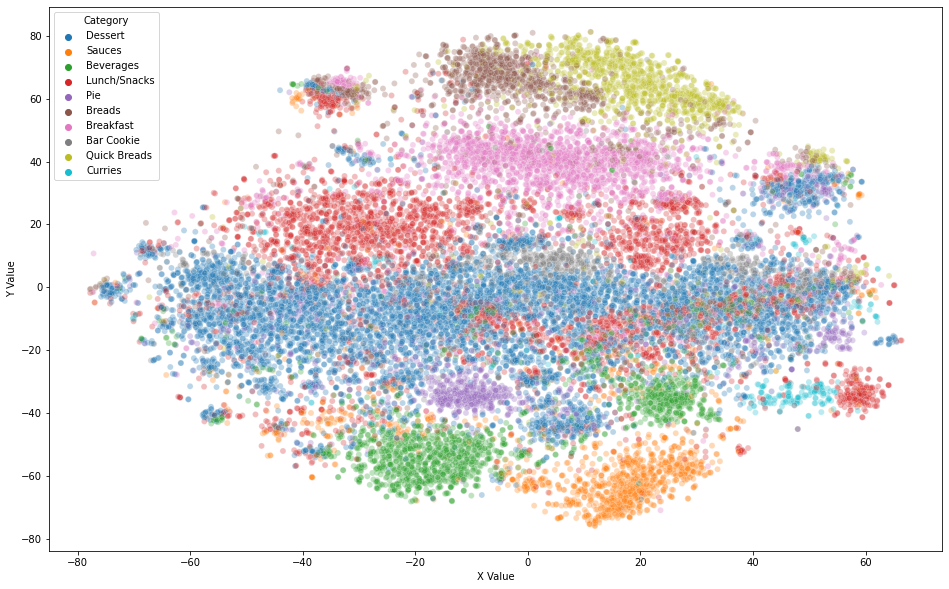

In [45]:
draw_scatter_per_category(values)

In [46]:
# draw_scatter_with_labels(values)

### Word2Vec

In [47]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, vectors_dict=concatenated_vectors_dict)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


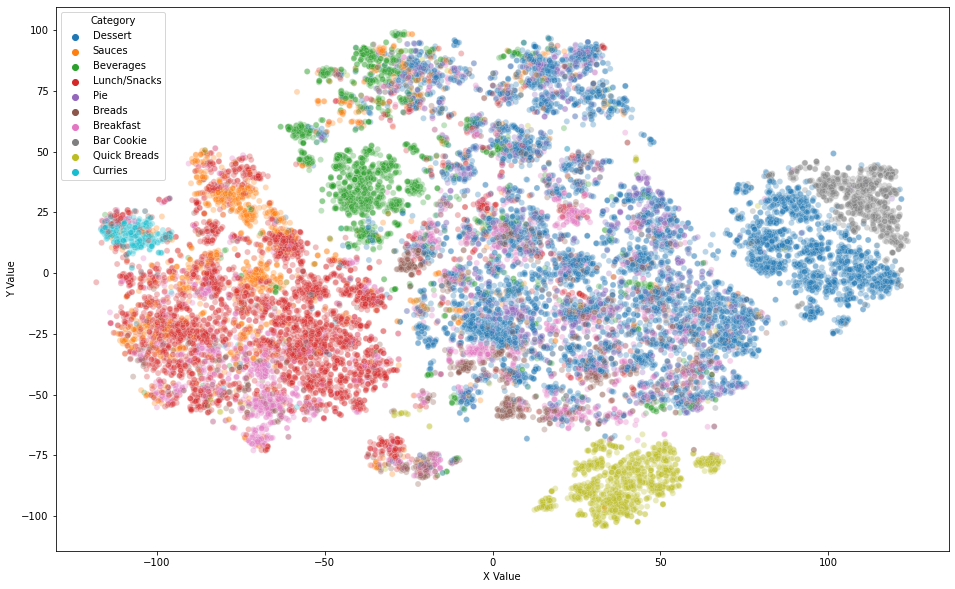

In [48]:
draw_scatter_per_category(values)

## Ingredients

### Doc2Vec

In [49]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, model=doc2vec_model_ingredients)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


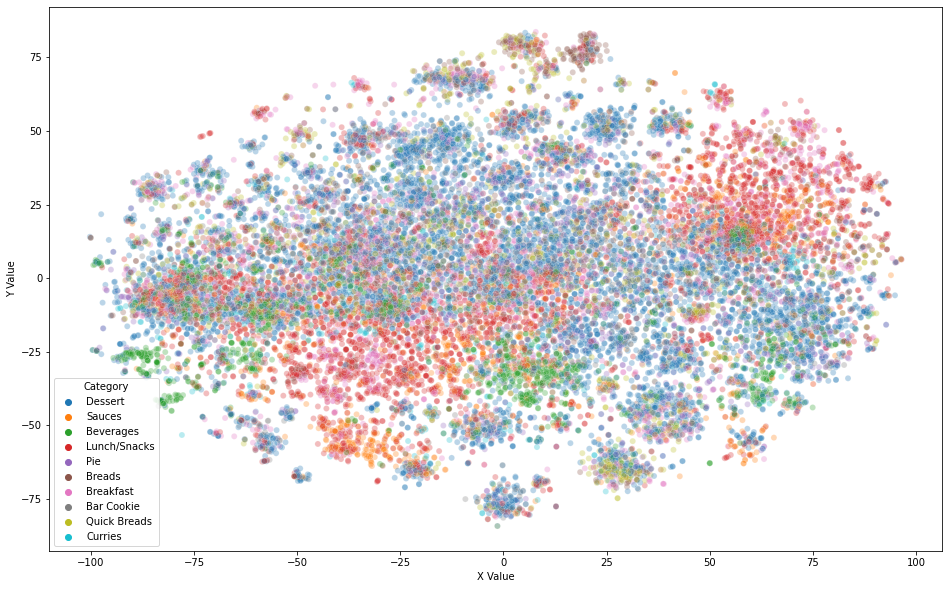

In [50]:
draw_scatter_per_category(values)

### Word2Vec

In [51]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, vectors_dict=ingredient_vectors_dict)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


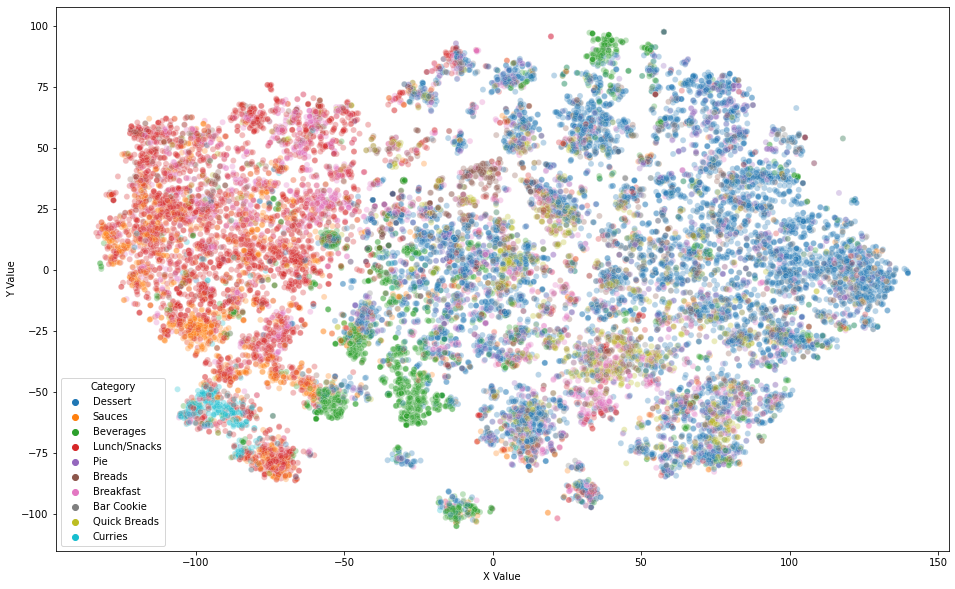

In [52]:
draw_scatter_per_category(values)

## Keywords

### Doc2Vec

In [53]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, model=doc2vec_model_keywords)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


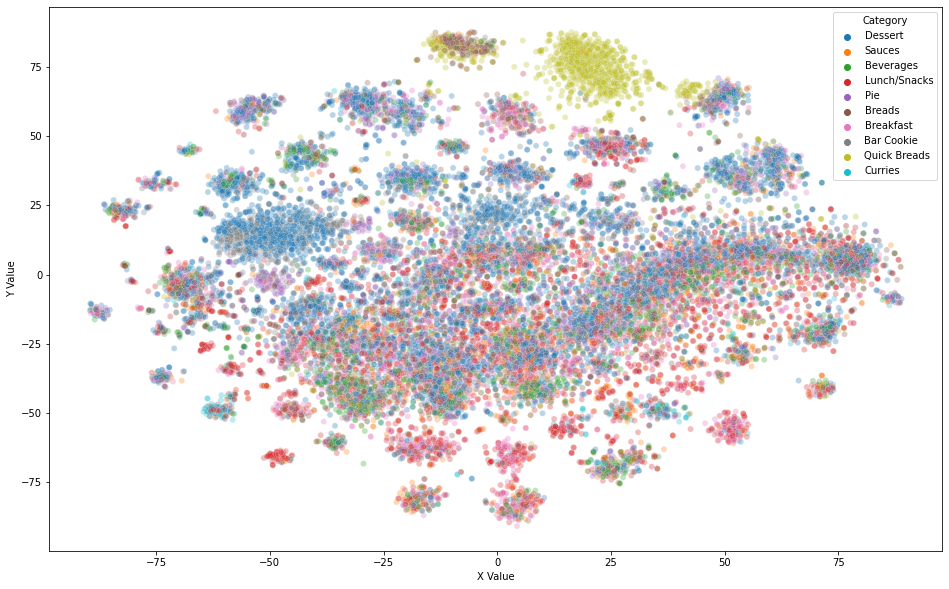

In [54]:
draw_scatter_per_category(values)

### Word2Vec

In [55]:
values = tsne_plot(word_labels=sample_recipes_names, categories_dict=sample_recipes_cats, vectors_dict=keyword_vectors_dict)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


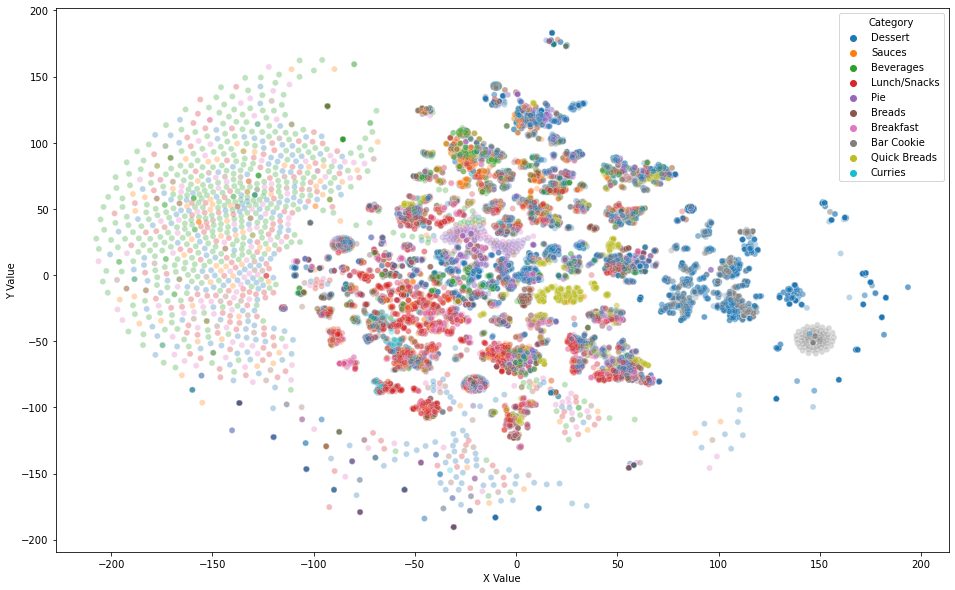

In [56]:
draw_scatter_per_category(values)

# SAVE FILES

## Constants

In [17]:
DOC2VEC_ING_MODEL = "../word_embeddings_files/models/doc2vec_ingredients_model.obj"
DOC2VEC_ING_CAT_MODEL = "../word_embeddings_files/models/doc2vec_ing_cat_model.obj"
DOC2VEC_ING_CAT_KEY_MODEL = "../word_embeddings_files/models/doc2vec_ing_cat_key_model.obj"

WORD2VEC_ING_MODEL = "../word_embeddings_files/models/word2vec_ingredients_model.obj"
WORD2VEC_ING_CAT_MODEL = "../word_embeddings_files/models/word2vec_ing_cat_model.obj"
WORD2VEC_ING_CAT_KEY_MODEL = "../word_embeddings_files/models/word2vec_ing_cat_key_model.obj"

# DOC2VEC_ING_VECTORS = "../word_embeddings_files/vectors/doc2vec_ingredients_vectors.obj"
# DOC2VEC_ING_CAT_VECTORS = "../word_embeddings_files/vectors/doc2vec_ing_cat_vectors.obj"
# DOC2VEC_ING_CAT_KEY_VECTORS = "../word_embeddings_files/vectors/doc2vec_ing_cat_key_vectors.obj"

WORD2VEC_ING_VECTORS = "../word_embeddings_files/vectors/word2vec_ingredients_vectors.obj"
WORD2VEC_ING_CAT_VECTORS = "../word_embeddings_files/vectors/word2vec_ing_cat_vectors.obj"
WORD2VEC_ING_CAT_KEY_VECTORS = "../word_embeddings_files/vectors/word2vec_ing_cat_key_vectors.obj"

In [31]:
# with open(DOC2VEC_ING_MODEL, 'wb') as pickle_file:
#     pickle.dump(doc2vec_model_ingredients, pickle_file)
    
# with open(DOC2VEC_ING_CAT_MODEL, 'wb') as pickle_file:
#     pickle.dump(doc2vec_model_concat_no_key, pickle_file)

# with open(DOC2VEC_ING_CAT_KEY_MODEL, 'wb') as pickle_file:
#     pickle.dump(doc2vec_model_concat, pickle_file)
    

    
# with open(WORD2VEC_ING_MODEL, 'wb') as pickle_file:
#     pickle.dump(model_ing, pickle_file)
    
# with open(WORD2VEC_ING_CAT_MODEL, 'wb') as pickle_file:
#     pickle.dump(model_no_key_concatenated, pickle_file)
    
# with open(WORD2VEC_ING_CAT_KEY_MODEL, 'wb') as pickle_file:
#     pickle.dump(model_concatenated, pickle_file)
    
    
    
# with open(WORD2VEC_ING_VECTORS, 'wb') as pickle_file:
#     pickle.dump(ingredient_vectors_dict, pickle_file)
    
# with open(WORD2VEC_ING_CAT_VECTORS, 'wb') as pickle_file:
#     pickle.dump(concatenated_no_key_vectors_dict, pickle_file)
    
# with open(WORD2VEC_ING_CAT_KEY_VECTORS, 'wb') as pickle_file:
#     pickle.dump(concatenated_vectors_dict, pickle_file)